This text summarization task is part of the projects done during NLP bootcamp at Indonesia AI.  
Other projects can be found at https://github.com/RobyKoeswojo/Indonesia-AI

In [ ]:
!pip install rouge_score loralib==0.1.1 peft==0.3.0 evaluate==0.4.0 --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, json, pprint, re, pickle, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Extract tar

In [ ]:
# !tar -xf "/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_2_text_summarization/data/liputan6_data.tar.gz" -C "/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_2_text_summarization/data/"

# Load Data

In [ ]:
# directories

data_path = "/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_2_text_summarization/data/"

folder_data = "liputan6_data"
dataset_type = "canonical"

train_dir = os.path.join(data_path, folder_data, dataset_type, "train")
val_dir = os.path.join(data_path, folder_data, dataset_type, "dev")
test_dir = os.path.join(data_path, folder_data, dataset_type, "test")

In [ ]:
print(len(os.listdir(train_dir)), len(os.listdir(val_dir)), len(os.listdir(test_dir)))

14682 10972 10972


In [ ]:
#################
### functions ###
#################
def unwrap_text(texts):
    text_string = ""
    for text in texts:
        text_string += " ".join(text)
        text_string += " "
    return re.sub(r'^.*?:', '', text_string).strip()

def get_data(dir, n_data=None):
    """ Collect all articles and summaries.

        Parameters
        ----------
        n_data: number of desired articles to be collected
     """
    data = []
    filenames = os.listdir(dir)
    for i in range(len(filenames)):
        try:
            json_data = json.load(open(os.path.join(dir, filenames[i])))
            article = unwrap_text(json_data['clean_article'])
            summary = unwrap_text(json_data['clean_summary'])
            data.append(dict(article=article, summary=summary))
        except Exception as e:
            print(f"Exception during processing {filenames[i]}: {e}")
            continue
        if n_data and len(data) == n_data: break
    return data

In [ ]:
# cross check clean article
unwrap_text(json.load(open(os.path.join(train_dir, "299993.json")))['clean_article'])

'Pengusaha ternama Donald Trump dikabarkan sedang mempertimbangkan untuk beralih ke dunia politik dengan mencalonkan diri sebagai presiden Amerika Serikat pada tahun 2012 , barubaru ini . Miliarder ini mengaku untuk perubahan karirnya dan memiliki keinginan untuk mengambil alih Gedung Putih dari kepemimpinan Barack Obama , karena dia mengkhawatirkan tentang keadaan industri manufaktur negara . Trump mengatakan kepada Fox News , " Saya sudah begitu banyak memiliki orang selama bertahun-tahun yang meminta saya untuk terjun ke dunia politik . Dan untuk pertama kalinya dalam hidup saya , saya benar-benar berpikir untuk melakukan hal itu , " ujar Trump . Namun , Trump juga mengaku khawatir ambisi politiknya mungkin tidak akan pernah membuahkan hasil . Ia menambahkan , " Saya belum tahu akan melakukannya . Dan ada kemungkinan juga saya tidak akan melakukannya , saya masih memikirkannya . " Gak yakin ya Trump . ( contactmusic/AYB ) .'

In [ ]:
# cross check clean summary
unwrap_text(json.load(open(os.path.join(train_dir, "299993.json")))['clean_summary'])

'Donald Trump dikabarkan sedang mempertimbangkan untuk beralih ke dunia politik dengan mencalonkan diri sebagai presiden Amerika Serikat pada tahun 2012 .'

Due to computing resource limitation, only use around 10% dataset:

In [ ]:
# collect data
train_data = get_data(train_dir, 150)
val_data = get_data(val_dir, 100)
test_data = get_data(test_dir, 100)

In [ ]:
# cross check
print(len(train_data), len(val_data), len(test_data))

print(train_data[0].keys())
print(train_data[0]['article'])
print(train_data[0]['summary'])

150 100 100
dict_keys(['article', 'summary'])
Kemenangan kini yang dicari tim Prancis dan Meksiko setelah sebelumnya bermain imbang . Di grup A , tercatat Prancis bermain tanpa gol melawan Uruguay , sementara Meksiko bermain imbang 1-1 saat bertemu Afrika Selatan . Kedua tim akan bertanding di Stadion Peter Mokaba , Polokwane , Afrika Selatan , Kamis ( 17/6 ) . Javier Aguirre , pelatih Meksiko mengatakan timnya akan fokus bermain baik dan menang . El Tri pun diuntungkan dengan pulihnya penyerang mereka , Rafael Marquez . Meksiko pun pantas percaya diri mengingat Prancis sedikit bermasalah dalam kekompakan tim . Bertaburkan pemain bintang , tim Les Blues dikhawatirkan kurang solid karena para pemain terjebak pada ego masing-masing . Walau begitu , Meksiko tak menganggap remeh Prancis . Marquez dan kawan-kawan tetap mewaspadai permainan menyerang Les Blues . Kedua tim juga ingin memperbaiki posisi di klasemen , mengingat pertandingan sebelumnya di grup A , Uruguay menang atas Afsel 3-0 [

In [ ]:
# save
with open(os.path.join(data_path, "train_data.pkl"), "wb") as fp:
    pickle.dump(train_data, fp)
with open(os.path.join(data_path, "val_data.pkl"), "wb") as fp:
    pickle.dump(val_data, fp)
with open(os.path.join(data_path, "test_data.pkl"), "wb") as fp:
    pickle.dump(test_data, fp)

# Exploratory Data Analysis  


In [ ]:
# load processed dataset
with open(os.path.join(data_path, "train_data.pkl"), "rb") as fp:
    train_data = pickle.load(fp)

with open(os.path.join(data_path, "val_data.pkl"), "rb") as fp:
    val_data = pickle.load(fp)

In [ ]:
print(len(train_data), len(val_data))

150 100


In [ ]:
# cross check
train_data[0]

{'article': 'Kemenangan kini yang dicari tim Prancis dan Meksiko setelah sebelumnya bermain imbang . Di grup A , tercatat Prancis bermain tanpa gol melawan Uruguay , sementara Meksiko bermain imbang 1-1 saat bertemu Afrika Selatan . Kedua tim akan bertanding di Stadion Peter Mokaba , Polokwane , Afrika Selatan , Kamis ( 17/6 ) . Javier Aguirre , pelatih Meksiko mengatakan timnya akan fokus bermain baik dan menang . El Tri pun diuntungkan dengan pulihnya penyerang mereka , Rafael Marquez . Meksiko pun pantas percaya diri mengingat Prancis sedikit bermasalah dalam kekompakan tim . Bertaburkan pemain bintang , tim Les Blues dikhawatirkan kurang solid karena para pemain terjebak pada ego masing-masing . Walau begitu , Meksiko tak menganggap remeh Prancis . Marquez dan kawan-kawan tetap mewaspadai permainan menyerang Les Blues . Kedua tim juga ingin memperbaiki posisi di klasemen , mengingat pertandingan sebelumnya di grup A , Uruguay menang atas Afsel 3-0 [ baca : Forlan Cerahkan Peluang "

## Length

In [ ]:
len(train_data[0]['article'])

1015

In [ ]:
def plot_length(dataset, plot_name):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    plt.suptitle(plot_name)

    for i, content in enumerate(['article', 'summary']):
        len_data = [len(x[content]) for x in dataset]
        sns.histplot(len_data, ax=axs[i])
        axs[i].set_title(f"{content} Length")
        axs[i].set_xlabel(f"{content}")
        print(f"Average length of {content}: {np.mean(len_data)}")
    plt.show()

Average length of article: 1168.38
Average length of summary: 170.46


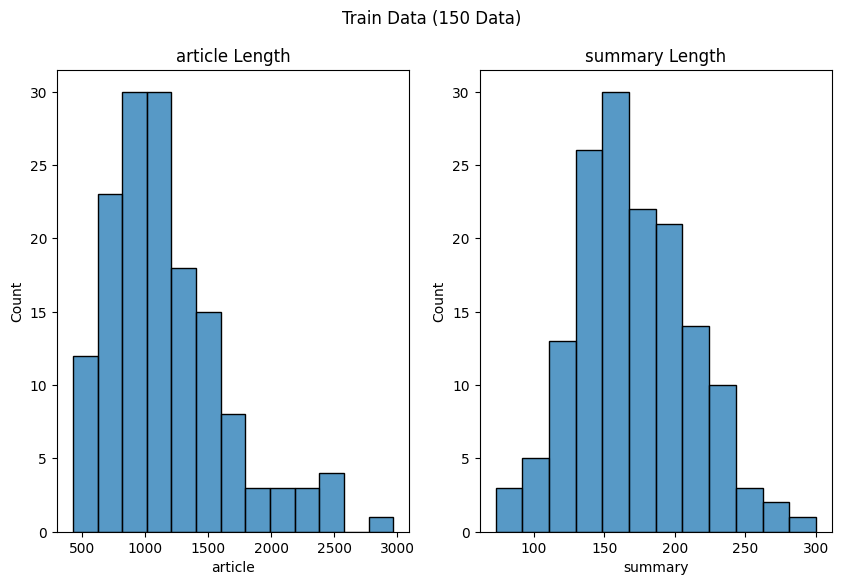

In [ ]:
plot_length(train_data, "Train Data (150 Data)")

Average length of article: 1367.67
Average length of summary: 174.31


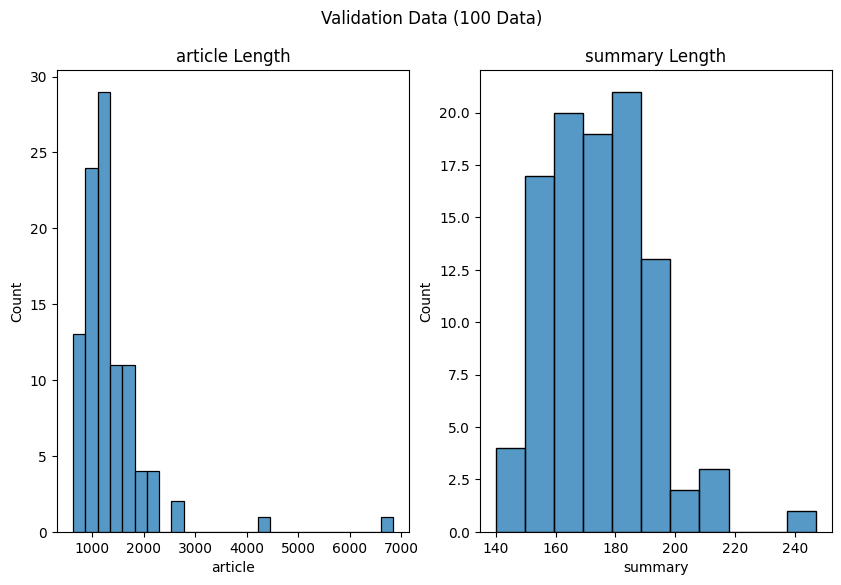

In [ ]:
plot_length(val_data, "Validation Data (100 Data)")

Findings:
- Some articles in the validation set has length > 3000 words  
- But in general, the average length for both article and summary in the train set is similar to validation set

## Most Frequent Words (UniGram, BiGram)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def plot_top_ngram(n_gram, dataset, plot_name):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    plot_name += f"-- top 10 {n_gram}-gram words"
    plt.suptitle(plot_name)


    for i, content in enumerate(['article', 'summary']):
        all_data = [x[content] for x in dataset]

        vec = CountVectorizer(ngram_range=(n_gram, n_gram)).fit(all_data)
        bag_of_words = vec.transform(all_data)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        word, count_word = map(list, zip(*freq[:10]))  # top 10 words

        sns.barplot(x=count_word, y=word, ax=axs[i])
        axs[i].set_title(f"{content} Length")
        axs[i].set_xlabel(f"count")
        axs[i].set_ylabel("n_gram_words")
    plt.tight_layout()
    plt.show()

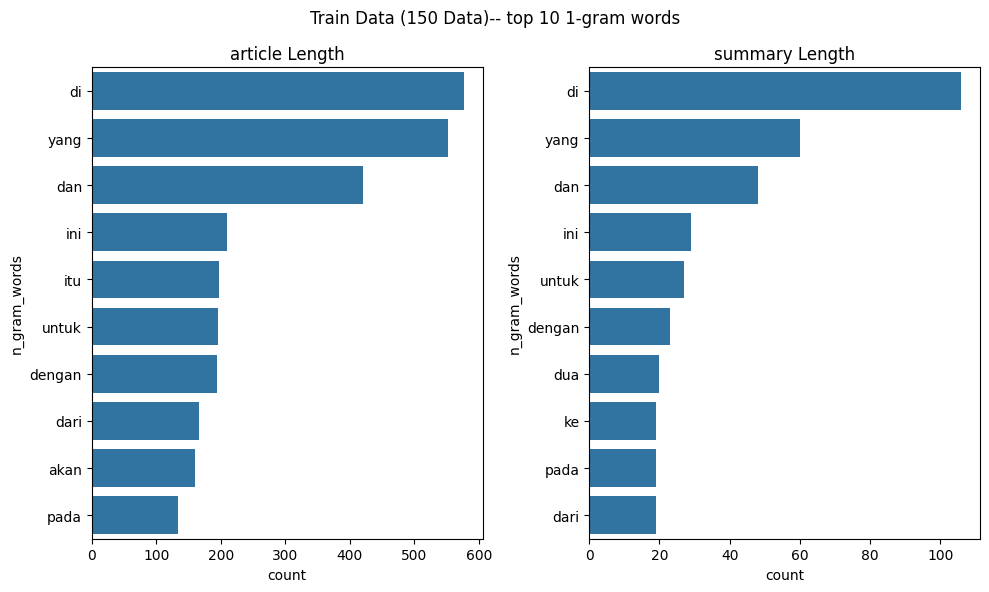

In [ ]:
# unigram train set
plot_top_ngram(1, train_data, "Train Data (150 Data)")

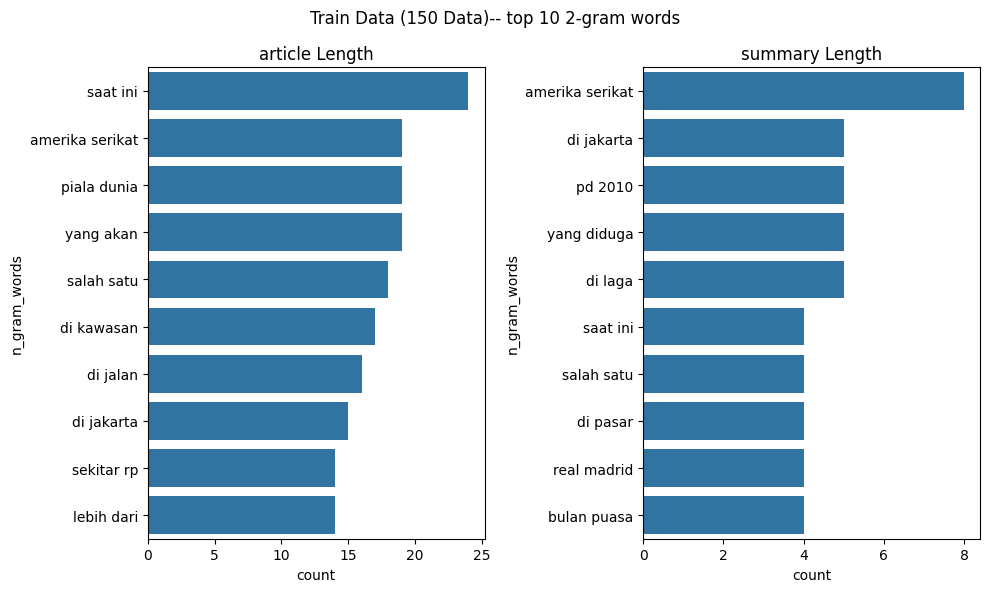

In [ ]:
# bigram train set
plot_top_ngram(2, train_data, "Train Data (150 Data)")

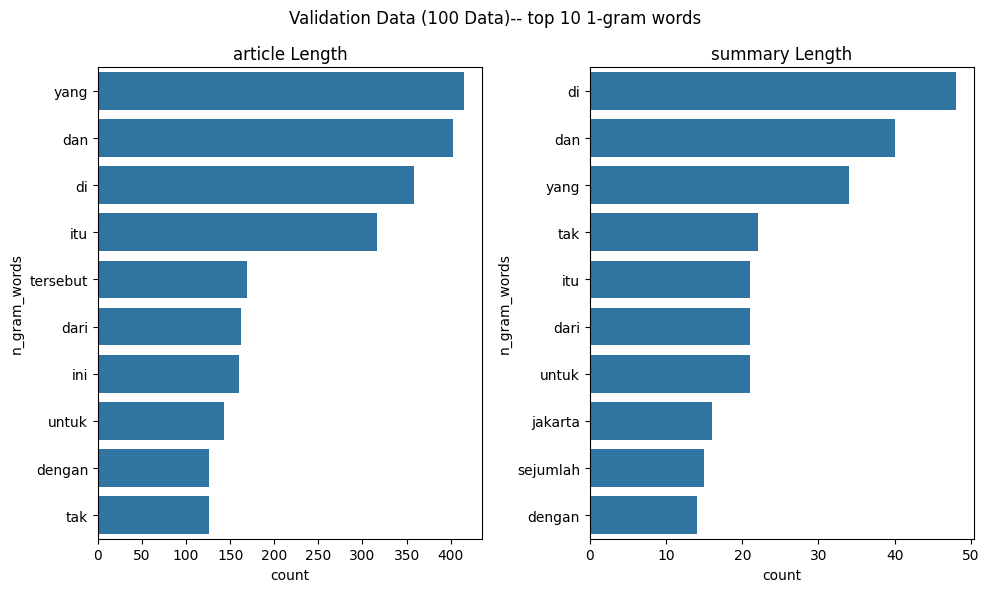

In [ ]:
# unigram validation set
plot_top_ngram(1, val_data, "Validation Data (100 Data)")

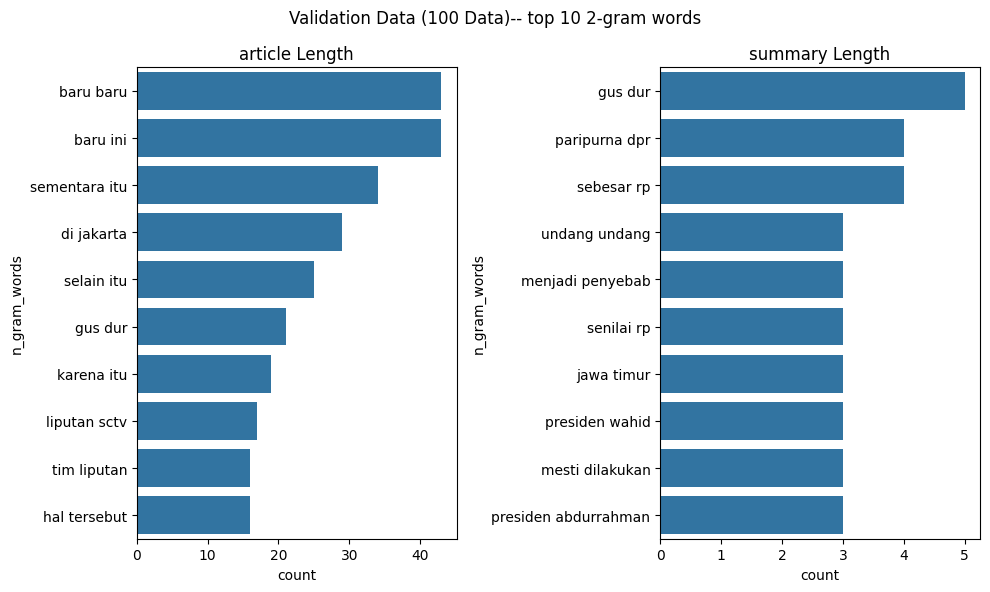

In [ ]:
# bigram validation set
plot_top_ngram(2, val_data, "Validation Data (100 Data)")

## WordCloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      max_font_size=30,
                      scale=3,
                      random_state=42)

def plot_wordcloud(dataset, plot_name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 12))
    # plt.suptitle(f"WordCloud for {plot_name}")
    for i, content in enumerate(['article', 'summary']):
        corpus = []
        for data in dataset:
            corpus.extend(data[content].split())

        wc = wordcloud.generate(str(corpus))
        axs[i].imshow(wc)
        axs[i].axis('off')
        axs[i].set_title(f"{content}")

    plt.show()


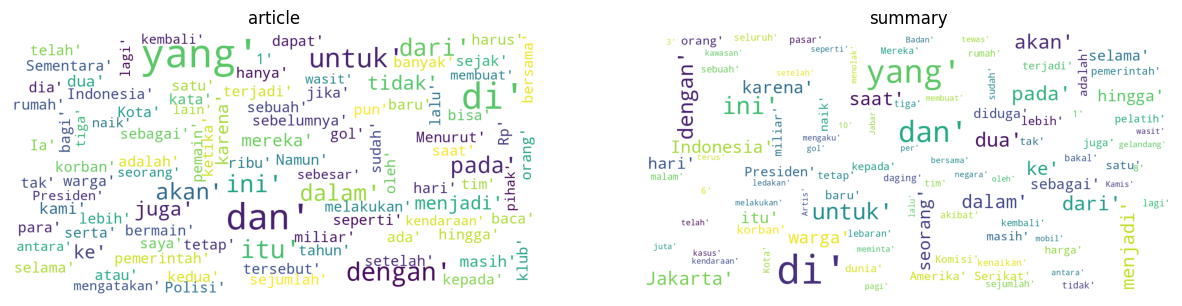

In [ ]:
# wordcloud train set
plot_wordcloud(train_data, "Train Data")

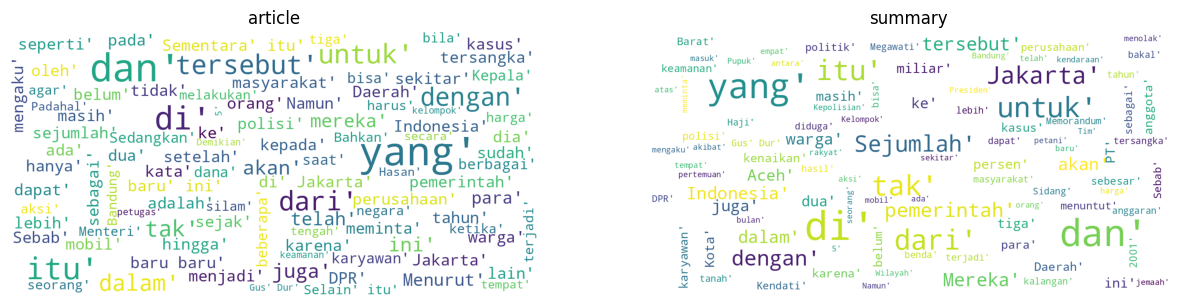

In [ ]:
# wordcloud validation set
plot_wordcloud(val_data, "Validation Data")

Findings: checking the 1-gram and 2-grams from the sampled data, it can be seen that the conjuction words are dominating both the articles and summaries

# Prediction

In [ ]:
import torch, evaluate
from rouge_score import rouge_scorer

In [ ]:
with open(os.path.join(data_path, "train_data.pkl"), "rb") as fp:
    train_data = pickle.load(fp)

with open(os.path.join(data_path, "val_data.pkl"), "rb") as fp:
    val_data = pickle.load(fp)

# rouge
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rougeL'],
                                  use_stemmer=True)

## Indonesian BERT2GPT Summarization Model
sc: https://huggingface.co/cahya/bert2gpt-indonesian-summarization

In [ ]:
from transformers import BertTokenizer, EncoderDecoderModel

model_name = "cahya/bert2gpt-indonesian-summarization"

# define tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

# define model
model = EncoderDecoderModel.from_pretrained(model_name)
# encoderdecodermodel does not support device_map=auto

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.26k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

In [ ]:
# check model's detail
model

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Generating summaries for 50 articles in validation data:

In [ ]:
# use only 50 samples
data = val_data[:50]

result = pd.DataFrame(columns=['article', 'true_summary', 'generated_summary',
                               'rouge1_precision', 'rouge1_recall', 'rouge1_score',
                               'rouge2_precision', 'rouge2_recall', 'rouge2_score',
                               'rouge3_precision', 'rouge3_recall', 'rouge3_score',
                               'rougeL_precision', 'rougeL_recall', 'rougeL_score',
                               ])


for i, document in enumerate(tqdm(data)):
    article, summary = document['article'], document['summary']
    article = re.sub(r"[^0-9a-zA-Z\s]", "", article)  # remove non alnum characters
    try:
        inputs = tokenizer.encode(article,
                                  return_tensors='pt') # encode
        summary_ids = model.generate(inputs, max_new_tokens=200) # generate
        generated_summary = tokenizer.decode(summary_ids[0],
                                             skip_special_tokens=True) # decode

        scores = scorer.score(summary, generated_summary) # calculate rogue score

        # collect results
        new_row = {
            'article': article,
            'true_summary': summary,
            'generated_summary': generated_summary,
            'rouge1_precision': scores['rouge1'][0],
            'rouge1_recall': scores['rouge1'][1],
            'rouge1_score': scores['rouge1'][2],
            'rouge2_precision': scores['rouge2'][0],
            'rouge2_recall': scores['rouge2'][1],
            'rouge2_score': scores['rouge2'][2],
            'rouge3_precision': scores['rouge3'][0],
            'rouge3_recall': scores['rouge3'][1],
            'rouge3_score': scores['rouge3'][2],
            'rougeL_precision': scores['rougeL'][0],
            'rougeL_recall': scores['rougeL'][1],
            'rougeL_score': scores['rougeL'][2],
        }
        result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)
    except Exception as e:
        print(f"Unable to process {i}-th data: {e}")
        continue

In [ ]:
# check result
result

,article,true_summary,generated_summary,rouge1_precision,rouge1_recall,rouge1_score,rouge2_precision,rouge2_recall,rouge2_score,rouge3_precision,rouge3_recall,rouge3_score,rougeL_precision,rougeL_recall,rougeL_score
0,Tim Search and Rescue SAR dari Lapangan Udar...,"Setelah dua pekan , upaya pencarian korban kec...",tim sar dari lapangan udara kalijati subang ja...,0.187500,0.260870,0.218182,0.064516,0.090909,0.075472,0.000000,0.000000,0.000000,0.093750,0.130435,0.109091
1,Omzet pedagang pakaian jadi di International T...,Kenaikan bahan pokok mempengaruhi omzet pedaga...,omzet pedagang pakaian jadi di international t...,0.470588,0.727273,0.571429,0.303030,0.476190,0.370370,0.250000,0.400000,0.307692,0.382353,0.590909,0.464286
2,Soal impor beras memang menjadi polemik belaka...,Kekhawatiran soal penyalahgunaan impor beras o...,menteri pertanian bungaran saragih memastikan ...,0.148148,0.160000,0.153846,0.038462,0.041667,0.040000,0.000000,0.000000,0.000000,0.111111,0.120000,0.115385
3,Eksplorasi elemenelemen dekoratif seni rupa da...,Keterpesonaan masyarakat modern terhadap unsur...,perupa patrianto mengubah diri bak anak blaste...,0.185185,0.192308,0.188679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.115385,0.113208
4,Penyelesaian persoalan di Aceh adalah pertarun...,DPR masih membahas rancangan Undang-undang Nan...,penyelesaian persoalan di aceh adalah pertarun...,0.461538,0.545455,0.500000,0.320000,0.380952,0.347826,0.291667,0.350000,0.318182,0.423077,0.500000,0.458333
5,Sekitar 250 pekerja CV Jaya Furniture sudah ti...,Karyawan CV Jaya Furniture terpaksa menginap d...,sekitar 250 pekerja cv jaya furniture sudah ti...,0.310345,0.360000,0.333333,0.107143,0.125000,0.115385,0.037037,0.043478,0.040000,0.275862,0.320000,0.296296
6,Masih banyak yang terlupakan di Yogyakarta Sa...,Kondisi benda-benda bersejarah di Puro Pakuala...,sejumlah benda bersejarah di puro pakualaman t...,0.550000,0.578947,0.564103,0.473684,0.500000,0.486486,0.388889,0.411765,0.400000,0.550000,0.578947,0.564103
7,Ratusan petani cabe merah di Kabupaten Kulonpr...,Pupuk ZA di Yogyakarta menghilang di pasaran ....,ratusan petani cabe merah di kabupaten kulonpr...,0.428571,0.576923,0.491803,0.176471,0.240000,0.203390,0.030303,0.041667,0.035088,0.228571,0.307692,0.262295
8,Sebanyak 18 ketua Kelompok Tani Kapas mengaduk...,Belasan ketua Kelompok Tani Kapas mengadukan k...,sebanyak 18 ketua kelompok tani kapas mengaduk...,0.382353,0.565217,0.456140,0.272727,0.409091,0.327273,0.218750,0.333333,0.264151,0.382353,0.565217,0.456140
9,Pekerjaan para pengangkut barang atau porter m...,Sejumlah porter yang kerap beraksi di Asrama H...,sekitar 30 orang porter mengaku tak mematok ta...,0.200000,0.260870,0.226415,0.034483,0.045455,0.039216,0.000000,0.000000,0.000000,0.133333,0.173913,0.150943


In [ ]:
# save result
result.to_csv(os.path.join(data_path, "result_pretrained-bert2bert.csv"), index=False)

In [ ]:
# calculate averaged rouge score
stats = {}

for col in result.columns:
    if col in ['article', 'true_summary', 'generated_summary']: continue
    stats[col] = result[col].mean()

stats

{'rouge1_precision': 0.33646996814263497,
 'rouge1_recall': 0.4238151102554667,
 'rouge1_score': 0.37310548678452526,
 'rouge2_precision': 0.16954410433491984,
 'rouge2_recall': 0.21557669790682446,
 'rouge2_score': 0.1887867471106929,
 'rouge3_precision': 0.09721301104049164,
 'rouge3_recall': 0.12551370521652455,
 'rouge3_score': 0.10903147417634809,
 'rougeL_precision': 0.2642798307314269,
 'rougeL_recall': 0.3303684486495093,
 'rougeL_score': 0.2920817416610824}

In [ ]:
result = pd.read_csv(os.path.join(data_path + "result_pretrained-bert2bert.csv"))
result[['article', 'true_summary', 'generated_summary']]

## FLAN T-5 XL   

sc: https://huggingface.co/google/flan-t5-xl  

prompt_template: https://github.com/google-research/FLAN/blob/main/flan/v2/flan_templates_branched.py

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
model_name = "google/flan-t5-xl"

# define model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name, torch_dtype=torch.bfloat16, device_map='auto')

tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
# generate summaries for 50 data in validation set
data = val_data[:50]

result = pd.DataFrame(columns=['article', 'true_summary', 'generated_summary',
                               'rouge1_precision', 'rouge1_recall', 'rouge1_score',
                               'rouge2_precision', 'rouge2_recall', 'rouge2_score',
                               'rouge3_precision', 'rouge3_recall', 'rouge3_score',
                               'rougeL_precision', 'rougeL_recall', 'rougeL_score',
                               ])


for i, document in enumerate(tqdm(data)):
    article, summary = document['article'], document['summary']
    article = re.sub(r"[^0-9a-zA-Z\s]", "", article)  # remove non alnum characters
    try:
        prompt = f"summarize: {article}"
        inputs = tokenizer.encode(prompt,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt').to("cuda")  # encode
        summary_ids = model.generate(inputs, max_new_tokens=200) # generate
        generated_summary = tokenizer.decode(summary_ids[0],
                                             skip_special_tokens=True) # decode

        scores = scorer.score(summary, generated_summary) # calculate rogue score

        # collect results
        new_row = {
            'article': article,
            'true_summary': summary,
            'generated_summary': generated_summary,
            'rouge1_precision': scores['rouge1'][0],
            'rouge1_recall': scores['rouge1'][1],
            'rouge1_score': scores['rouge1'][2],
            'rouge2_precision': scores['rouge2'][0],
            'rouge2_recall': scores['rouge2'][1],
            'rouge2_score': scores['rouge2'][2],
            'rouge3_precision': scores['rouge3'][0],
            'rouge3_recall': scores['rouge3'][1],
            'rouge3_score': scores['rouge3'][2],
            'rougeL_precision': scores['rougeL'][0],
            'rougeL_recall': scores['rougeL'][1],
            'rougeL_score': scores['rougeL'][2],
        }
        result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)
    except Exception as e:
        print(f"Unable to process {i}-th data: {e}")
        continue

100%|██████████| 50/50 [07:15<00:00,  8.70s/it]


In [ ]:
result

,article,true_summary,generated_summary,rouge1_precision,rouge1_recall,rouge1_score,rouge2_precision,rouge2_recall,rouge2_score,rouge3_precision,rouge3_recall,rouge3_score,rougeL_precision,rougeL_recall,rougeL_score
0,Tim Search and Rescue SAR dari Lapangan Udar...,"Setelah dua pekan , upaya pencarian korban kec...",Angkatan Udara RI juga menemukan tiga korban d...,0.145161,0.391304,0.211765,0.081967,0.227273,0.120482,0.016667,0.047619,0.024691,0.080645,0.217391,0.117647
1,Omzet pedagang pakaian jadi di International T...,Kenaikan bahan pokok mempengaruhi omzet pedaga...,- SCTV berkata omzet pedagang pakaian jadi yan...,0.085106,0.181818,0.115942,0.065217,0.142857,0.089552,0.044444,0.100000,0.061538,0.085106,0.181818,0.115942
2,Dua penghuni Lembaga Pemasyarakatan Cipinang k...,Dua tahanan kabur dari LP Cipinang . Pelarian ...,- PT LP Cipinang mengatakan keduanya melarikan...,0.089552,0.250000,0.131868,0.015152,0.043478,0.022472,0.000000,0.000000,0.000000,0.044776,0.125000,0.065934
3,Soal impor beras memang menjadi polemik belaka...,Kekhawatiran soal penyalahgunaan impor beras o...,summary: Soal impor beras memang menjadi polem...,0.216667,0.520000,0.305882,0.050847,0.125000,0.072289,0.000000,0.000000,0.000000,0.150000,0.360000,0.211765
4,Eksplorasi elemenelemen dekoratif seni rupa da...,Keterpesonaan masyarakat modern terhadap unsur...,Eksplorasi elemenelemen dekoratif seni rupa da...,0.140351,0.307692,0.192771,0.053571,0.120000,0.074074,0.036364,0.083333,0.050633,0.105263,0.230769,0.144578
5,Penyelesaian persoalan di Aceh adalah pertarun...,DPR masih membahas rancangan Undang-undang Nan...,adalah pembahasan RUU Nanggroe Aceh Darussalam...,0.600000,0.409091,0.486486,0.500000,0.333333,0.400000,0.384615,0.250000,0.303030,0.600000,0.409091,0.486486
6,Sekitar 250 pekerja CV Jaya Furniture sudah ti...,Karyawan CV Jaya Furniture terpaksa menginap d...,adalah bahwa kepala kantor Depnaker tidak memb...,0.218182,0.480000,0.300000,0.092593,0.208333,0.128205,0.056604,0.130435,0.078947,0.181818,0.400000,0.250000
7,Masih banyak yang terlupakan di Yogyakarta Sa...,Kondisi benda-benda bersejarah di Puro Pakuala...,Puro Pakualaman merupakan kasus kerajaan yang ...,0.250000,0.789474,0.379747,0.169492,0.555556,0.259740,0.137931,0.470588,0.213333,0.233333,0.736842,0.354430
8,Ratusan petani cabe merah di Kabupaten Kulonpr...,Pupuk ZA di Yogyakarta menghilang di pasaran ....,- Ratusan pekan merah terancam gagal gagal kel...,0.314286,0.846154,0.458333,0.188406,0.520000,0.276596,0.073529,0.208333,0.108696,0.271429,0.730769,0.395833
9,Sebanyak 18 ketua Kelompok Tani Kapas mengaduk...,Belasan ketua Kelompok Tani Kapas mengadukan k...,Sebanyak 18 ketua Kelompok Tani Kapas mengaduk...,0.307692,0.869565,0.454545,0.250000,0.727273,0.372093,0.206349,0.619048,0.309524,0.292308,0.826087,0.431818


In [ ]:
# save result
result.to_csv(os.path.join(data_path, "result_pretrained_flan-t5-xl.csv"), index=False)

In [ ]:
# calculate rouge scores
stats = {}

for col in result.columns:
    if col in ['article', 'true_summary', 'generated_summary']: continue
    stats[col] = result[col].mean()

stats

{'rouge1_precision': 0.1961460578244089,
 'rouge1_recall': 0.4593295776443037,
 'rouge1_score': 0.25524285690961207,
 'rouge2_precision': 0.09698467308258425,
 'rouge2_recall': 0.23678327597057575,
 'rouge2_score': 0.1281501515819193,
 'rouge3_precision': 0.057678157898605996,
 'rouge3_recall': 0.13487916081764512,
 'rouge3_score': 0.0727443112956462,
 'rougeL_precision': 0.1532281557851568,
 'rougeL_recall': 0.3530145707480476,
 'rougeL_score': 0.19763239716094744}

In [ ]:
result = pd.read_csv(os.path.join(data_path, "result_pretrained_flan-t5-xl.csv"))
result[['article', 'true_summary', 'generated_summary']]

The result is not as good as the result using Indonesian BERT2BERT model.  This seems logical since this model is not fine-tuned on the specific id-liputan6 dataset

## PEFT FLAN-T5 SMALL  
Because of the limitation when using google colab free, this PEFT model uses FLAN T5 Small


In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import (AutoModelForSeq2SeqLM, AutoTokenizer,
                          GenerationConfig, TrainingArguments, Trainer,
                          DataCollatorForSeq2Seq)
from datasets import Dataset

In [ ]:
model_name = "google/flan-t5-small"

# define model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name, torch_dtype=torch.bfloat16, device_map='auto')

tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
# to check number of trainable parameters
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [ ]:
print_number_of_trainable_model_parameters(model)

'\ntrainable model parameters: 76961152\nall model parameters: 76961152\npercentage of trainable model parameters: 100.00%'

Reformat the data for Dataset loading:

In [ ]:
new_train_data = {'article': [], 'summary': []}

for i in range(len(train_data)):
    new_train_data['article'].append(train_data[i]['article'])
    new_train_data['summary'].append(train_data[i]['summary'])

train_dataset = Dataset.from_dict(new_train_data)

In [ ]:
# cross check
train_dataset[0]

{'article': 'Kemenangan kini yang dicari tim Prancis dan Meksiko setelah sebelumnya bermain imbang . Di grup A , tercatat Prancis bermain tanpa gol melawan Uruguay , sementara Meksiko bermain imbang 1-1 saat bertemu Afrika Selatan . Kedua tim akan bertanding di Stadion Peter Mokaba , Polokwane , Afrika Selatan , Kamis ( 17/6 ) . Javier Aguirre , pelatih Meksiko mengatakan timnya akan fokus bermain baik dan menang . El Tri pun diuntungkan dengan pulihnya penyerang mereka , Rafael Marquez . Meksiko pun pantas percaya diri mengingat Prancis sedikit bermasalah dalam kekompakan tim . Bertaburkan pemain bintang , tim Les Blues dikhawatirkan kurang solid karena para pemain terjebak pada ego masing-masing . Walau begitu , Meksiko tak menganggap remeh Prancis . Marquez dan kawan-kawan tetap mewaspadai permainan menyerang Les Blues . Kedua tim juga ingin memperbaiki posisi di klasemen , mengingat pertandingan sebelumnya di grup A , Uruguay menang atas Afsel 3-0 [ baca : Forlan Cerahkan Peluang "

In [ ]:
# mapping
prefix = "summarize: "

def tokenize_function(example):
    start_prompt = "summarize: \n\n"

    prompt = [start_prompt + article for article in example['article']]
    example['input_ids'] = tokenizer(prompt,
                                     padding=True,
                                     truncation=True,
                                     return_tensors='pt')['input_ids']
    example['labels'] = tokenizer(example['summary'],
                                  padding=True,
                                  truncation=True,
                                  return_tensors='pt')['input_ids']
    return example

tokenized_train_data = train_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
# cross check
tokenized_train_data

Dataset({
    features: ['article', 'summary', 'input_ids', 'labels'],
    num_rows: 150
})

In [ ]:
# remove unused columns
tokenized_train_data = tokenized_train_data.remove_columns(['article', 'summary'])

In [ ]:
# cross check
tokenizer.decode(tokenized_train_data[1]['input_ids'])

'summarize: Keberadaan SJ alias Sjahril Johan sampai saat ini masih menjadi misteri. Satuan Tugas Pemberantasan Mafia Hukum pun menerima informasi yang berubah-ubah mengenai keberadaan SJ. Demikian diungkapkan Sekretaris Satgas Denny Indrayana di Jakarta, Senin ( 12/4 ). Ada yang mengatakan SJ di Australia, Singapura, dan bahkan di Jakarta. " Kita selalu koordinasi di mana yang bersangkutan berada, memang itu menjadi misteri tersendiri. Tapi yang bersangkutan penting didengar keterangannya dan kita harap dalam waktu dekat bisa dilakukan, " ujarnya. Satgas telah berkoordinasi dengan Mabes Polri supaya dapat meminta keterangan dari Sjahril Johan pada kesempatan pertama setelah keberadaannya ditemukan. Untuk kepentingan itu Ketua Satgas Kuntoro Mangkusubroto telah berkomunikasi dengan Kapolri Jenderal Pol Bambang Hendarso Danuri. Denny menambahkan, keterangan Susno saat diperiksa memberi gambaran utuh mengenai modus praktik sindikasi mafia hukum yang terjadi berserta orang-orang yang terl

In [ ]:
tokenizer.decode(tokenized_train_data[1]['labels'])

'Keberadaan SJ alias Sjahril Johan sampai saat ini masih menjadi misteri. Ada yang mengatakan SJ di Australia, Singapura, dan bahkan di Jakarta.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

Train LORA:

In [ ]:
# define hparams
lora_config = LoraConfig(r=32, # rank
                         lora_alpha=32,
                         target_modules=['q', 'v'],
                         lora_dropout=0.05,
                         bias='none',
                         task_type=TaskType.SEQ_2_SEQ_LM # flan-t5
                         )

peft_model = get_peft_model(model, lora_config)

In [ ]:
print_number_of_trainable_model_parameters(peft_model)

'\ntrainable model parameters: 1376256\nall model parameters: 78337408\npercentage of trainable model parameters: 1.76%'

In [ ]:
output_dir = os.path.join(data_path, "peft-training")
training_args = TrainingArguments(output_dir=output_dir,
                                  auto_find_batch_size=True,
                                  learning_rate=1e-3,
                                  num_train_epochs=1,
                                  weight_decay=0.01,
                                  logging_steps=1,
                                  )



trainer = Trainer(model=peft_model,
                  args=training_args,
                #   data_collator=data_collator,
                  train_dataset=tokenized_train_data,)

trainer.train()

peft_model_path = os.path.join(data_path, "./peft-dialogue-summary-checkpoint-local")

trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

Step,Training Loss
1,24.875000
2,20.000000
3,26.875000
4,21.125000
5,19.875000
6,20.000000
7,18.875000
8,16.750000
9,18.375000
10,16.625000


('/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_2_text_summarization/data/./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_2_text_summarization/data/./peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_2_text_summarization/data/./peft-dialogue-summary-checkpoint-local/spiece.model',
 '/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_2_text_summarization/data/./peft-dialogue-summary-checkpoint-local/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_2_text_summarization/data/./peft-dialogue-summary-checkpoint-local/tokenizer.json')

Load LORA:

In [ ]:
from peft import PeftModel, PeftConfig

In [ ]:
peft_model = PeftModel.from_pretrained(model,
                                       os.path.join(data_path, "peft-dialogue-summary-checkpoint-local"),
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [ ]:
# cross check
article, summary = val_data[0]['article'], val_data[0]['summary']
article = re.sub(r"[^0-9a-zA-Z\s]", "", article)  # remove non alnum characters

prompt = f"summarize: {article}"
inputs = tokenizer.encode(prompt,
                            padding=True,
                            truncation=True,
                            return_tensors='pt')  # encode

gen_config = GenerationConfig(max_new_tokens=200)
peft_outputs = peft_model.generate(input_ids=inputs,
                                    generation_config=gen_config)


In [ ]:
print(summary)

Setelah dua pekan , upaya pencarian korban kecelakaan helikopter Bell N-412 membuahkan hasil . Pesawat naas dengan tiga korban akan dievakuasi pada siang ini .


In [ ]:
print(tokenizer.decode(peft_outputs[0]))

<pad> Angkatan Udara RI juga menemukan tadi Pesawat yang membawa Kapten Pilot Bobby Copilot Sutjahyono Wahyu mekanik Jatmiko serta dua penumpang itu tadi Pesawat yang membawa Kapten Pilot Bobby Copilot Sutjahyono Wahyu mekanik Jatmiko serta dua penumpang itu tadi Pesawat yang membawa Kapten Pilot Bobby Copilot Sutjahyono Wahyu mekanik Jatmiko serta dua penumpang itu tadi Pesawat yang membawa Kapten Pilot Bobby Copilot Sutjahyono Wahyu meka


Predict:

In [ ]:
# use only 50 samples
data = val_data[:50]

result = pd.DataFrame(columns=['article', 'true_summary', 'generated_summary',
                               'rouge1_precision', 'rouge1_recall', 'rouge1_score',
                               'rouge2_precision', 'rouge2_recall', 'rouge2_score',
                               'rouge3_precision', 'rouge3_recall', 'rouge3_score',
                               'rougeL_precision', 'rougeL_recall', 'rougeL_score',
                               ])


for i, document in enumerate(tqdm(data)):
    article, summary = document['article'], document['summary']
    article = re.sub(r"[^0-9a-zA-Z\s]", "", article)  # remove non alnum characters
    try:
        prompt = f"summarize: {article}"
        inputs = tokenizer.encode(prompt,
                                  padding=True,
                                  truncation=True,
                                  return_tensors='pt')  # encode

        gen_config = GenerationConfig(max_new_tokens=200)
        peft_outputs = peft_model.generate(input_ids=inputs,
                                           generation_config=gen_config)

        generated_summary = tokenizer.decode(peft_outputs[0],
                                             skip_special_tokens=True) # decode

        scores = scorer.score(summary, generated_summary) # calculate rogue score

        # collect results
        new_row = {
            'article': article,
            'true_summary': summary,
            'generated_summary': generated_summary,
            'rouge1_precision': scores['rouge1'][0],
            'rouge1_recall': scores['rouge1'][1],
            'rouge1_score': scores['rouge1'][2],
            'rouge2_precision': scores['rouge2'][0],
            'rouge2_recall': scores['rouge2'][1],
            'rouge2_score': scores['rouge2'][2],
            'rouge3_precision': scores['rouge3'][0],
            'rouge3_recall': scores['rouge3'][1],
            'rouge3_score': scores['rouge3'][2],
            'rougeL_precision': scores['rougeL'][0],
            'rougeL_recall': scores['rougeL'][1],
            'rougeL_score': scores['rougeL'][2],
        }
        result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)
    except Exception as e:
        print(f"Unable to process {i}-th data: {e}")
        continue

100%|██████████| 50/50 [19:53<00:00, 23.86s/it]


In [ ]:
result

,article,true_summary,generated_summary,rouge1_precision,rouge1_recall,rouge1_score,rouge2_precision,rouge2_recall,rouge2_score,rouge3_precision,rouge3_recall,rouge3_score,rougeL_precision,rougeL_recall,rougeL_score
0,Tim Search and Rescue SAR dari Lapangan Udar...,"Setelah dua pekan , upaya pencarian korban kec...",Angkatan Udara RI juga menemukan tadi Pesawat ...,0.031250,0.086957,0.045977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.086957,0.045977
1,Omzet pedagang pakaian jadi di International T...,Kenaikan bahan pokok mempengaruhi omzet pedaga...,"The International Trade Center Mangga Dua, Jak...",0.166667,0.227273,0.192308,0.137931,0.190476,0.160000,0.107143,0.150000,0.125000,0.166667,0.227273,0.192308
2,Dua penghuni Lembaga Pemasyarakatan Cipinang k...,Dua tahanan kabur dari LP Cipinang . Pelarian ...,LP Cipinang Jumat 162 dini hari Terang saja pe...,0.037736,0.083333,0.051948,0.019231,0.043478,0.026667,0.000000,0.000000,0.000000,0.037736,0.083333,0.051948
3,Soal impor beras memang menjadi polemik belaka...,Kekhawatiran soal penyalahgunaan impor beras o...,The swaats of the Sebab swaats are a swaat of ...,0.014706,0.040000,0.021505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.040000,0.021505
4,Eksplorasi elemenelemen dekoratif seni rupa da...,Keterpesonaan masyarakat modern terhadap unsur...,The Patrianto spokesman said that the Patriant...,0.040000,0.038462,0.039216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.038462,0.039216
5,Penyelesaian persoalan di Aceh adalah pertarun...,DPR masih membahas rancangan Undang-undang Nan...,Aceh yang tahu ji ji ji ji ji ji ji ji ji ji j...,0.015152,0.045455,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.045455,0.022727
6,Sekitar 250 pekerja CV Jaya Furniture sudah ti...,Karyawan CV Jaya Furniture terpaksa menginap d...,YYTSentot Noerachman dan Binsar Rahardian - ad...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Masih banyak yang terlupakan di Yogyakarta Sa...,Kondisi benda-benda bersejarah di Puro Pakuala...,"During the day, the twelfth day of the month, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Ratusan petani cabe merah di Kabupaten Kulonpr...,Pupuk ZA di Yogyakarta menghilang di pasaran ....,YYTWiwik Susilo dan Mardiyanto - a spokesman f...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Sebanyak 18 ketua Kelompok Tani Kapas mengaduk...,Belasan ketua Kelompok Tani Kapas mengadukan k...,"TNAIwan Taruna, TNAIwan Taruna, TNAIwan Taruna...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# save result
result.to_csv(os.path.join(data_path, "result_peft-flan-t5-small.csv"), index=False)

In [ ]:
#
stats = {}

for col in result.columns:
    if col in ['article', 'true_summary', 'generated_summary']: continue
    stats[col] = result[col].mean()

stats

{'rouge1_precision': 0.054725243273871814,
 'rouge1_recall': 0.0980435218480985,
 'rouge1_score': 0.06213680399957339,
 'rouge2_precision': 0.017299284917606888,
 'rouge2_recall': 0.04017109682418606,
 'rouge2_score': 0.023636203548462745,
 'rouge3_precision': 0.00828451023957292,
 'rouge3_recall': 0.019926155969634228,
 'rouge3_score': 0.011490227002261823,
 'rougeL_precision': 0.04922044162390888,
 'rougeL_recall': 0.0877792469925193,
 'rougeL_score': 0.055824047402074035}

In [ ]:
result = pd.read_csv(os.path.join(data_path + "result_peft-flan-t5-small.csv"))
result[['article', 'true_summary', 'generated_summary']]

,article,true_summary,generated_summary
0,Tim Search and Rescue SAR dari Lapangan Udar...,"Setelah dua pekan , upaya pencarian korban kec...",Angkatan Udara RI juga menemukan tadi Pesawat ...
1,Omzet pedagang pakaian jadi di International T...,Kenaikan bahan pokok mempengaruhi omzet pedaga...,"The International Trade Center Mangga Dua, Jak..."
2,Dua penghuni Lembaga Pemasyarakatan Cipinang k...,Dua tahanan kabur dari LP Cipinang . Pelarian ...,LP Cipinang Jumat 162 dini hari Terang saja pe...
3,Soal impor beras memang menjadi polemik belaka...,Kekhawatiran soal penyalahgunaan impor beras o...,The swaats of the Sebab swaats are a swaat of ...
4,Eksplorasi elemenelemen dekoratif seni rupa da...,Keterpesonaan masyarakat modern terhadap unsur...,The Patrianto spokesman said that the Patriant...
5,Penyelesaian persoalan di Aceh adalah pertarun...,DPR masih membahas rancangan Undang-undang Nan...,Aceh yang tahu ji ji ji ji ji ji ji ji ji ji j...
6,Sekitar 250 pekerja CV Jaya Furniture sudah ti...,Karyawan CV Jaya Furniture terpaksa menginap d...,YYTSentot Noerachman dan Binsar Rahardian - ad...
7,Masih banyak yang terlupakan di Yogyakarta Sa...,Kondisi benda-benda bersejarah di Puro Pakuala...,"During the day, the twelfth day of the month, ..."
8,Ratusan petani cabe merah di Kabupaten Kulonpr...,Pupuk ZA di Yogyakarta menghilang di pasaran ....,YYTWiwik Susilo dan Mardiyanto - a spokesman f...
9,Sebanyak 18 ketua Kelompok Tani Kapas mengaduk...,Belasan ketua Kelompok Tani Kapas mengadukan k...,"TNAIwan Taruna, TNAIwan Taruna, TNAIwan Taruna..."


The PEFT-FLAN-T5-Small model is underperforming and this is possibly because of:
- the model does not understand Bahasa Indonesia yet
- the size of the model is very small

Other NLP projects during NLP bootcamp at Indonesia AI can be found at https://github.com/RobyKoeswojo/Indonesia-AI